In [2]:
from src.data.load_data import load_dataset
from src.data.preprocess import clean_dataset
from src.visualization.eda import plot_eda
from src.models.train_model import split_data, plot_roc_curve
from src.models.knn_model import train_knn_model
from src.models.dumb_model import train_dumb_model
from src.visualization.performance import (
    plot_confusion_matrices,
    plot_performance_comparison,
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
print("---Loading data...")
raw_df = load_dataset("data/raw/train.csv")
test_df = load_dataset("data/raw/test.csv")

# Print shape of the raw dataset
print(f"Raw dataset shape: {raw_df.shape}")

---Loading data...
Raw dataset shape: (303124, 15)


In [14]:
raw_df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Tenure               float64
Usage Frequency        int64
Support Calls         object
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Customer Status       object
Last Due Date         object
Last Payment Date     object
Churn                  int64
dtype: object

In [15]:
raw_df.isnull().sum()

CustomerID               0
Age                      0
Gender                   0
Tenure               62021
Usage Frequency          0
Support Calls        62420
Payment Delay        88324
Subscription Type        0
Contract Length          0
Total Spend              0
Last Interaction     62550
Customer Status          0
Last Due Date            0
Last Payment Date        0
Churn                    0
dtype: int64

In [16]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_column(df: pd.DataFrame, column_name: str, column_labels: dict) -> pd.DataFrame:
    """One-hot encode a specified column in the DataFrame."""
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[column_name]]).toarray())
    df = df.join(encoder_df)
    df.rename(columns=column_labels, inplace=True)
    df.drop(column_name, axis=1, inplace=True)
    return df


In [4]:
# Impute missing numeric values with the median of the respective columns
cleanup_df = raw_df.copy()

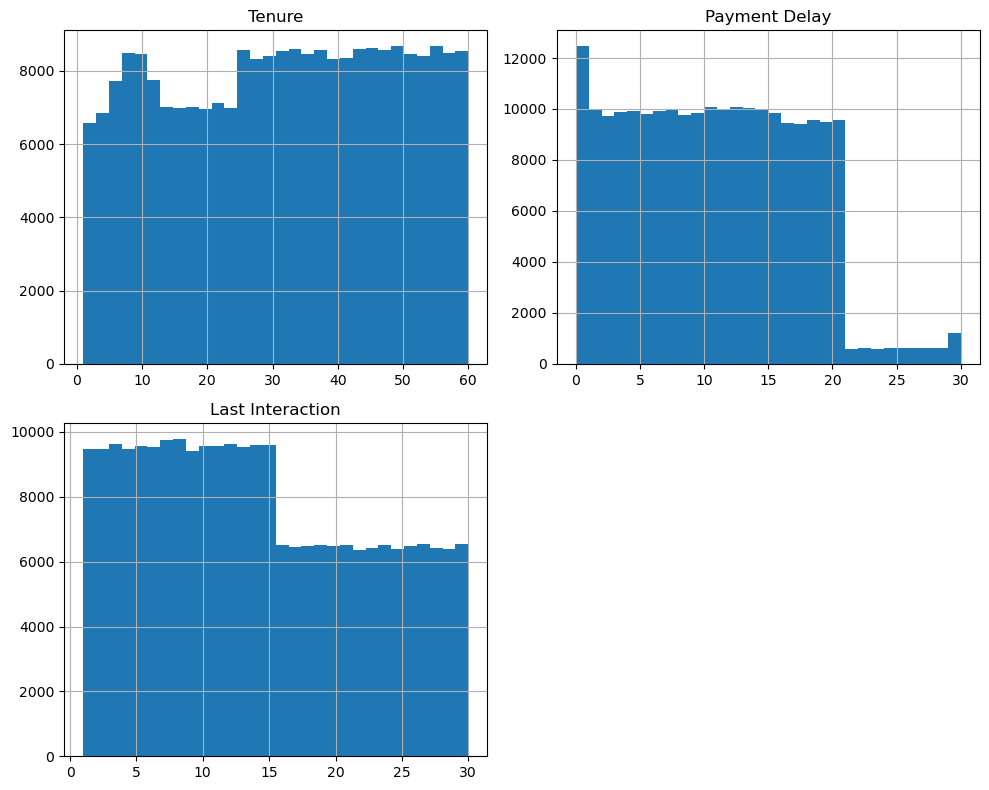

In [5]:
# plot distributions for Tenure, Support Calls, Payment Delay, and Last Interaction
cleanup_df[['Tenure', 'Support Calls', 'Payment Delay', 'Last Interaction']].hist(bins=30, figsize=(10, 8))
plt.tight_layout()

In [18]:
cleanup_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn
0,160831,34,Male,NaN,26,none,17.0,Basic,Quarterly,890.21,30.0,active,06-21,07-08,0
1,354435,30,Male,36.0,22,NaN,15.0,Basic,Annual,954.37,30.0,active,06-10,06-25,0
2,444576,23,Male,44.0,14,none,NaN,Premium,Annual,674.00,21.0,inactive,06-27,07-21,1
3,130847,24,Male,39.0,21,2,14.0,Standard,Quarterly,775.00,18.0,active,06-30,07-14,0
4,108121,26,Male,NaN,26,1,5.0,Basic,Quarterly,679.45,NaN,active,06-29,07-04,0


In [6]:
cleanup_df.isna().sum()

CustomerID               0
Age                      0
Gender                   0
Tenure               62021
Usage Frequency          0
Support Calls        62420
Payment Delay        88324
Subscription Type        0
Contract Length          0
Total Spend              0
Last Interaction     62550
Customer Status          0
Last Due Date            0
Last Payment Date        0
Churn                    0
dtype: int64

In [8]:
cleanup_df[['Payment Delay', 'Last Due Date','Last Payment Date']].head(3)

,Payment Delay,Last Due Date,Last Payment Date
0,17.0,06-21,07-08
1,15.0,06-10,06-25
2,NaN,06-27,07-21


In [9]:

# Convert dates to datetime (use any placeholder year)
due = pd.to_datetime(cleanup_df['Last Due Date'], format='%m-%d')
paid = pd.to_datetime(cleanup_df['Last Payment Date'], format='%m-%d')

# Compute delay in days
computed_delay = (paid - due).dt.days

# Only fill missing values in Payment Delay
cleanup_df.loc[cleanup_df['Payment Delay'].isna(), 'Payment Delay'] = computed_delay[cleanup_df['Payment Delay'].isna()]

In [20]:
cleanup_df[cleanup_df.isnull().sum()[cleanup_df.isnull().sum() > 0].index].dtypes

Tenure              float64
Support Calls        object
Payment Delay       float64
Last Interaction    float64
dtype: object

In [21]:
cleanup_df[["Tenure", "Payment Delay", "Last Interaction"]].head()

,Tenure,Payment Delay,Last Interaction
0,NaN,17.0,30.0
1,36.0,15.0,30.0
2,44.0,NaN,21.0
3,39.0,14.0,18.0
4,NaN,5.0,NaN


In [22]:
# impute Tenure, Payment Delay, and Last Interaction with mean values

# cleanup_df = cleanup_df.fillna(cleanup_df.mode()) #improve imputation later
cleanup_df['Tenure'] = cleanup_df['Tenure'].fillna(cleanup_df['Tenure'].mean())
cleanup_df['Last Interaction'] = cleanup_df['Last Interaction'].fillna(cleanup_df['Last Interaction'].mean())

# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS
# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS
# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS
# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS
# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS
# HEY FUTURE NOAH YOU SHOULD PROBABLY LOOK AT THIS

# try both to see which is better
# cleanup_df['Payment Delay'] = cleanup_df['Payment Delay'].fillna(cleanup_df['Payment Delay'].mean())
# cleanup_df['Payment Delay'] = cleanup_df['Payment Delay'].fillna(-1)


In [23]:

# remove Customer Status till I figure out how to fix it lol
# cleanup_df.drop("Customer Status", axis=1, inplace=True)

In [24]:
# Perform one-hot encoding on Gender, Subscription Type, Contract Length, and Customer Status columns
cleanup_df = one_hot_encode_column(cleanup_df, 'Gender', {0: 'Female', 1: 'Male'})
cleanup_df = one_hot_encode_column(cleanup_df, 'Subscription Type', {0: 'Basic', 1: 'Premium', 2: 'Standard'})
cleanup_df = one_hot_encode_column(cleanup_df, 'Contract Length', {0: 'Monthly', 1: 'Quarterly', 2: 'Yearly'})
cleanup_df = one_hot_encode_column(cleanup_df, 'Customer Status', {0: 'Active', 1: 'Inactive'})

In [25]:
cleanup_df.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Last Due Date,Last Payment Date,...,Female,Male,Basic,Premium,Standard,Monthly,Quarterly,Yearly,Active,Inactive
0,160831,34,31.530657,26,none,17.0,890.21,30.000000,06-21,07-08,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,354435,30,36.000000,22,NaN,15.0,954.37,30.000000,06-10,06-25,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,444576,23,44.000000,14,none,NaN,674.00,21.000000,06-27,07-21,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,130847,24,39.000000,21,2,14.0,775.00,18.000000,06-30,07-14,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,108121,26,31.530657,26,1,5.0,679.45,14.051415,06-29,07-04,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [26]:
# Ensure that both datasets have Active and Inactive columns after one-hot encoding
if 'Inactive' not in cleanup_df.columns:
    cleanup_df['Inactive'] = 0

In [27]:
# Replace 'none' and nan with 0 in Support Calls column
cleanup_df['Support Calls'] = cleanup_df['Support Calls'].replace('none', 0)
cleanup_df['Support Calls'] = cleanup_df['Support Calls'].fillna(0)
cleanup_df['Support Calls'] = cleanup_df['Support Calls'].astype(int)


In [28]:
# Cleaning Payment Delay, Last Interaction, and Tenure Columns
# cleanup_df['Payment Delay'] = cleanup_df['Payment Delay'].fillna(-1)
cleanup_df['Last Interaction'] = cleanup_df['Last Interaction'].fillna(cleanup_df['Last Interaction'].mean())
cleanup_df['Tenure'] = cleanup_df['Tenure'].fillna(cleanup_df['Tenure'].mean())

In [29]:
# Drop Last Due Date and Last Payment Date until I can figure out how to process em
# cleanup_df = cleanup_df.drop(['Last Due Date', 'Last Payment Date'], axis=1)

cleanup_df['Last Due Date'].nunique()

# one hot encode Last Due Date and Last Payment Date
# cleanup_df = one_hot_encode_column(cleanup_df, 'Last Due Date', {i: f'Last Due Date {i}' for i in range(cleanup_df['Last Due Date'].nunique())})  
# cleanup_df = one_hot_encode_column(cleanup_df, 'Last Payment Date', {i: f'Last Payment Date {i}' for i in range(cleanup_df['Last Payment Date'].nunique())})  

31

In [30]:
cleanup_df.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Last Due Date,Last Payment Date,...,Female,Male,Basic,Premium,Standard,Monthly,Quarterly,Yearly,Active,Inactive
0,160831,34,31.530657,26,0,17.0,890.21,30.000000,06-21,07-08,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,354435,30,36.000000,22,0,15.0,954.37,30.000000,06-10,06-25,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,444576,23,44.000000,14,0,NaN,674.00,21.000000,06-27,07-21,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,130847,24,39.000000,21,2,14.0,775.00,18.000000,06-30,07-14,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,108121,26,31.530657,26,1,5.0,679.45,14.051415,06-29,07-04,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [31]:
cleanup_df['Payment Delay'].value_counts()

Payment Delay
0.0     12463
12.0    10083
10.0    10064
13.0    10036
1.0     10002
11.0     9967
14.0     9960
7.0      9940
4.0      9934
6.0      9908
3.0      9882
15.0     9827
9.0      9827
5.0      9784
8.0      9778
2.0      9731
20.0     9578
18.0     9560
19.0     9479
16.0     9460
17.0     9412
27.0      635
22.0      633
28.0      630
24.0      629
26.0      617
25.0      616
30.0      604
29.0      598
21.0      589
23.0      574
Name: count, dtype: int64

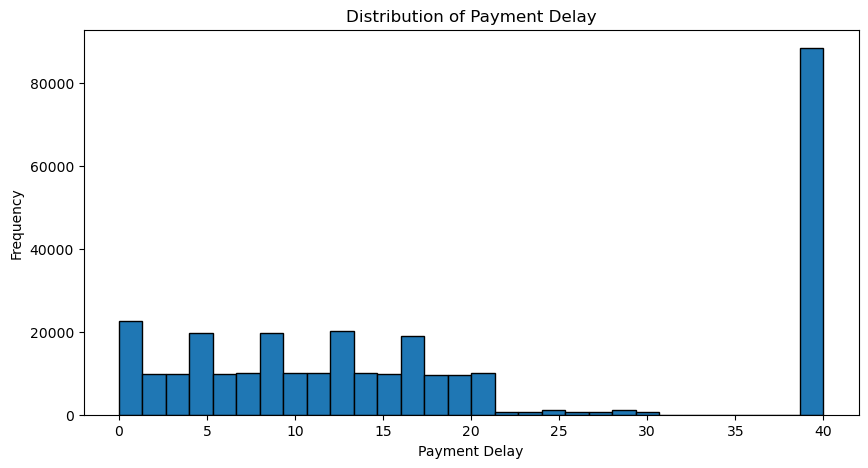

In [32]:
# plot the distribution of 'Payment Delay' to see how to best impute missing values
plt.figure(figsize=(10, 5)) 
import matplotlib.pyplot as plt
plt.hist(cleanup_df['Payment Delay'].fillna(40), bins=30, edgecolor='k')
plt.title('Distribution of Payment Delay')
plt.xlabel('Payment Delay')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

df = cleanup_df.copy()

# Split rows with/without missing Payment Delay
# set up a train test split for Payment Delay


mask_missing = df['Payment Delay'].isna()
train = df[~mask_missing]
test = df[mask_missing]

# Features to predict Payment Delay (use whatever makes sense)
features = ['Age','Tenure','Usage Frequency','Support Calls','Last Interaction']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

rf.fit(train[features], train['Payment Delay'])

cleanup_df.loc[mask_missing, 'Payment Delay'] = rf.predict(test[features])


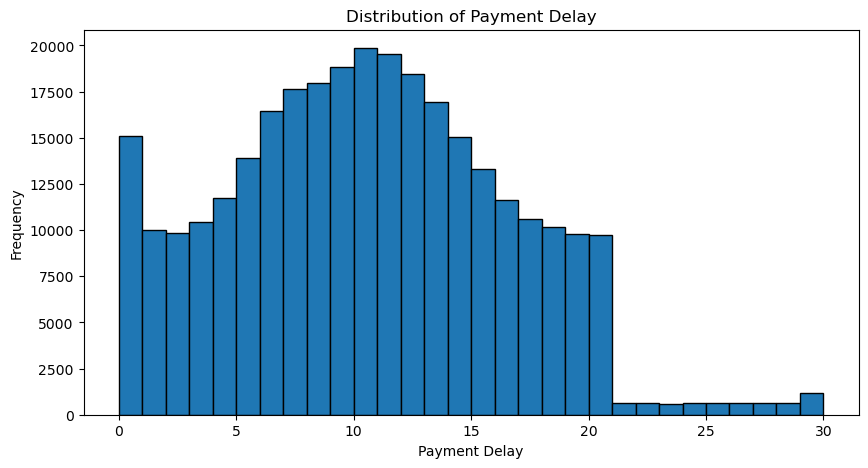

In [35]:
# plot the distribution of 'Payment Delay' to see how to best impute missing values
plt.figure(figsize=(10, 5)) 
import matplotlib.pyplot as plt
plt.hist(cleanup_df['Payment Delay'], bins=30, edgecolor='k')
plt.title('Distribution of Payment Delay')
plt.xlabel('Payment Delay')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# print("---Writing to csv...")
# clean_train_df.to_csv("data/processed/clean_train.csv", index=False)
# clean_test_df.to_csv("data/processed/clean_test.csv", index=False)

# # Print shape of the cleaned dataset
# print(f"Cleaned dataset shape: {clean_train_df.shape}")
# print(f"Cleaned test dataset shape: {clean_test_df.shape}")

